In [67]:
from matplotlib import pyplot as plt
import numpy as np
import random
import pickle

# loading training set features
f = open("Datasets/train_set_features.pkl", "rb")
train_set_features2 = pickle.load(f)
f.close()

# reducing feature vector length
features_STDs = np.std(a=train_set_features2, axis=0)
train_set_features = train_set_features2[:, features_STDs > 52.3]

# changing the range of data between 0 and 1
train_set_features = np.divide(train_set_features, train_set_features.max())

# loading training set labels
f = open("Datasets/train_set_labels.pkl", "rb")
train_set_labels = pickle.load(f)
f.close()

# ------------
# loading test set features
f = open("Datasets/test_set_features.pkl", "rb")
test_set_features2 = pickle.load(f)
f.close()

# reducing feature vector length
features_STDs = np.std(a=test_set_features2, axis=0)
test_set_features = test_set_features2[:, features_STDs > 48]

# changing the range of data between 0 and 1
test_set_features = np.divide(test_set_features, test_set_features.max())

# loading test set labels
f = open("Datasets/test_set_labels.pkl", "rb")
test_set_labels = pickle.load(f)
f.close()

# ------------
# preparing our training and test sets - joining datasets and lables
train_set = []
test_set = []

for i in range(len(train_set_features)):
    label = np.array([0, 0, 0, 0])
    label[int(train_set_labels[i])] = 1
    label = label.reshape(4, 1)
    train_set.append((train_set_features[i].reshape(102, 1), label))

for i in range(len(test_set_features)):
    label = np.array([0, 0, 0, 0])
    label[int(test_set_labels[i])] = 1
    label = label.reshape(4, 1)
    test_set.append((test_set_features[i].reshape(102, 1), label))

# shuffle
random.shuffle(train_set)
random.shuffle(test_set)

In [68]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def derivative_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

def feedforward(W, a, b, activation_func):
  z = (W @ a) + b
  if activation_func == 'sigmoid':
    return sigmoid(z)


W_1 = np.random.normal(size=(150, 102))
W_2 = np.random.normal(size=(60, 150))
W_3 = np.random.normal(size=(4, 60))
b_1 = np.zeros((150, 1))
b_2 = np.zeros((60, 1))
b_3 = np.zeros((4, 1))

correct_guesses = 0
number_of_samples = 200
train_sample_200 = random.sample(train_set, number_of_samples)

for train_data in train_sample_200:
    a0 = train_data[0]
    a1 = feedforward(W_1 , a0 , b_1, 'sigmoid')
    a2 = feedforward(W_2 , a1 , b_2, 'sigmoid')
    a3 = feedforward(W_3 , a2 , b_3, 'sigmoid')

    predicted_label = np.where(a3 == np.amax(a3))
    real_label = np.where(train_data[1] == np.amax(train_data[1]))

    if predicted_label == real_label:
        correct_guesses  += 1

print(f"Accuracy: {(correct_guesses  / number_of_samples) * 100}")


Accuracy: 22.5


Accuracy: 20.0


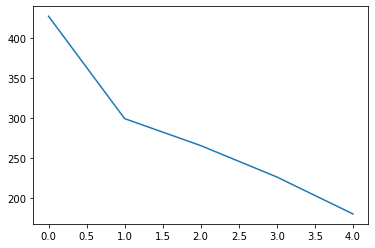

In [69]:
correct_guesses = 0
batch_size = 10
learning_rate = 1
number_of_epochs = 5


def initialize():
    w1 = np.random.standard_normal(size=(150, 102))
    b1 = np.zeros((150, 1))

    w2 = np.random.standard_normal(size=(60, 150))
    b2 = np.zeros((60, 1))

    w3 = np.random.standard_normal(size=(4, 60))
    b3 = np.zeros((4, 1))

    w = [w1, w2, w3]
    b = [b1, b2, b3]

    return w, b


W, b = initialize()
total_costs = []
for i in range(number_of_epochs):
    batches = [train_set[x:x + batch_size] for x in range(0, number_of_samples, batch_size)]
    for batch in batches:
        grad_W1 = np.zeros((150, 102))
        grad_b1 = np.zeros((150, 1))

        grad_W2 = np.zeros((60, 150))
        grad_b2 = np.zeros((60, 1))

        grad_W3 = np.zeros((4, 60))
        grad_b3 = np.zeros((4, 1))

        for image, label in batch:
            # forward propagation
            a1 = feedforward(W[0] , image , b[0], 'sigmoid')
            a2 = feedforward(W[1] , a1 , b[1], 'sigmoid')
            a3 = feedforward(W[2] , a2 , b[2], 'sigmoid')

            for j in range(grad_W3.shape[0]):
                for k in range(grad_W3.shape[1]):
                    grad_W3[j, k] += 2 * (a3[j, 0] - label[j, 0]) * a3[j, 0] * (1 - a3[j, 0]) * a2[k, 0]

            # bias
            for j in range(grad_b3.shape[0]):
                grad_b3[j, 0] += 2 * (a3[j, 0] - label[j, 0]) * a3[j, 0] * (1 - a3[j, 0])

            # ---- 3rd layer
            # activation
            grad_a3 = np.zeros((60, 1))

            for k in range(60):
                for j in range(4):
                    grad_a3[k, 0] += 2 * (a3[j, 0] - label[j, 0]) * a3[j, 0] * (1 - a3[j, 0]) * W[2][j, k]

            # weight
            for k in range(grad_W2.shape[0]):
                for m in range(grad_W2.shape[1]):
                    grad_W2[k, m] += grad_a3[k, 0] * a2[k, 0] * (1 - a2[k, 0]) * a1[m, 0]

            # bias
            for k in range(grad_b2.shape[0]):
                grad_b2[k, 0] += grad_a3[k, 0] * a2[k, 0] * (1 - a2[k, 0])

            # ---- 2nd layer
            # activation
            grad_a2 = np.zeros((150, 1))
            for m in range(150):
                for k in range(60):
                    grad_a2[m, 0] += grad_a3[k, 0] * a2[k, 0] * (1 - a2[k, 0]) * W[1][k, m]

            # weight
            for m in range(grad_W1.shape[0]):
                for v in range(grad_W1.shape[1]):
                    grad_W1[m, v] += grad_a2[m, 0] * a1[m, 0] * (1 - a1[m, 0]) * image[v, 0]

            # bias
            for m in range(grad_b1.shape[0]):
                grad_b1[m, 0] += grad_a2[m, 0] * a1[m, 0] * (1 - a1[m, 0])

        W[0] -= (learning_rate * (grad_W1 / batch_size))
        W[1] -= (learning_rate * (grad_W2 / batch_size))
        W[2] -= (learning_rate * (grad_W3 / batch_size))

        b[0] -= (learning_rate * (grad_b1 / batch_size))
        b[1] -= (learning_rate * (grad_b2 / batch_size))
        b[2] -= (learning_rate * (grad_b3 / batch_size))

    cost = 0
    for train_data in train_sample_200:
        a0 = train_data[0]
        a1 = feedforward(W[0] , a0 , b[0], 'sigmoid')
        a2 = feedforward(W[1] , a1 , b[1], 'sigmoid')
        a3 = feedforward(W[2] , a2 , b[2], 'sigmoid')

        for j in range(4):
            cost += np.power((a3[j, 0] - train_data[1][j,  0]), 2)

    total_costs.append(cost)

epoch_size = [x for x in range(number_of_epochs)]
plt.plot(epoch_size, total_costs)

for train_data in train_sample_200:
    a0 = train_data[0]
    a1 = feedforward(W[0] , a0 , b[0], 'sigmoid')
    a2 = feedforward(W[1] , a1 , b[1], 'sigmoid')
    a3 = feedforward(W[2] , a2 , b[2], 'sigmoid')

    predicted_label = np.argmax(a3 , axis=0)
    real_label = np.argmax(train_data[1], axis=0)


    if predicted_label[0] == real_label[0]:
        correct_guesses  += 1

print(f"Accuracy: {(correct_guesses / number_of_samples)*100}")

Accuracy: 100.0


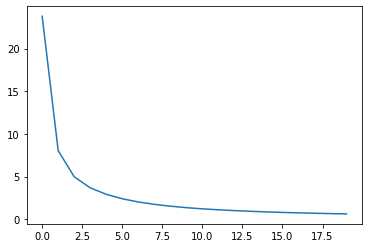

In [72]:
batch_size = 10
learning_rate = 1
number_of_epochs = 20
correct_guesses = 0
W, b = initialize()
total_costs = []
for i in range(number_of_epochs):
    batches = [train_set[x:x + batch_size] for x in range(0, len(train_set), batch_size)]
    for batch in batches:
        grad_W1 = np.zeros((150, 102))
        grad_b1 = np.zeros((150, 1))

        grad_W2 = np.zeros((60, 150))
        grad_b2 = np.zeros((60, 1))

        grad_W3 = np.zeros((4, 60))
        grad_b3 = np.zeros((4, 1))

        for image, label in batch:
            # forward propagation
            a1 = feedforward(W[0] , image , b[0], 'sigmoid')
            a2 = feedforward(W[1] , a1 , b[1], 'sigmoid')
            a3 = feedforward(W[2] , a2 , b[2], 'sigmoid')

            # ---- Last layer
            # weight
            grad_W3 += (2 * (a3 - label) * a3 * (1 - a3)) @ np.transpose(a2)
            # bias
            grad_b3 += 2 * (a3 - label) * a3 * (1 - a3)
            # ---- 3rd layer
            # activation
            grad_a3 = np.zeros((60, 1))
            grad_a3 += np.transpose(W[2]) @ (2 *(a3 - label) * (a3 * (1 - a3)))
            # weight
            grad_W2 += (a2 * (1 - a2) * grad_a3) @ np.transpose(a1)
            # bias
            grad_b2 += grad_a3 * a2 * (1 - a2)
            # ---- 2nd layer
            # activation
            grad_a2 = np.zeros((150, 1))
            grad_a2 += np.transpose(W[1]) @ (grad_a3 * a2 * (1 - a2))
            # weight
            grad_W1 += (grad_a2 * a1 * (1 - a1)) @ np.transpose(image)
            # bias
            grad_b1 += grad_a2 * a1 * (1 - a1)

        W[0] -= (learning_rate * (grad_W1 / batch_size))
        W[1] -= (learning_rate * (grad_W2 / batch_size))
        W[2] -= (learning_rate * (grad_W3 / batch_size))

        b[0] -= (learning_rate * (grad_b1 / batch_size))
        b[1] -= (learning_rate * (grad_b2 / batch_size))
        b[2] -= (learning_rate * (grad_b3 / batch_size))

    cost = 0
    for train_data in train_set:
        a0 = train_data[0]
        a1 = feedforward(W[0] , a0 , b[0], 'sigmoid')
        a2 = feedforward(W[1] , a1 , b[1], 'sigmoid')
        a3 = feedforward(W[2] , a2 , b[2], 'sigmoid')

        for j in range(4):
            cost += np.power((a3[j, 0] - train_data[1][j,  0]), 2)

    total_costs.append(cost)

epoch_size = [x for x in range(number_of_epochs)]
plt.plot(epoch_size, total_costs)

for train_data in train_set:
    a0 = train_data[0]
    a1 = feedforward(W[0] , a0 , b[0], 'sigmoid')
    a2 = feedforward(W[1] , a1 , b[1], 'sigmoid')
    a3 = feedforward(W[2] , a2 , b[2], 'sigmoid')

    predicted_label = np.argmax(a3 , axis=0)
    real_label = np.argmax(train_data[1], axis=0)


    if predicted_label[0] == real_label[0]:
        correct_guesses  += 1

print(f"Accuracy: {(correct_guesses / len(train_set))*100}")



